**Jupyter Kernel**:

* If you are in SageMaker Notebook instance, please make sure you are using **conda_pytorch_latest_p36** kernel
* If you are on SageMaker Studio, please make sure you are using **SageMaker JumpStart PyTorch 1.0** kernel

**Run All**:

* If you are in SageMaker notebook instance, you can go to *Cell tab -> Run All*
* If you are in SageMaker Studio, you can go to *Run tab -> Run All Cells*

**Note**: To *Run All* successfully, make sure you have executed the entire demo notebook `0_demo.ipynb` first.

## SageMaker Defect Detection Demo

In this notebook, we deploy an endpoint from a provided pretrained detection model that was already trained on **NEU-DET** dataset. Then, we send some image samples with defects for detection and visual the results

In [2]:
import json

import numpy as np

import sagemaker
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
sagemaker_config = json.load(open("../stack_outputs.json"))
role = sagemaker_config["IamRole"]
solution_bucket = sagemaker_config["SolutionS3Bucket"]
region = sagemaker_config["AWSRegion"]
solution_name = sagemaker_config["SolutionName"]
bucket = sagemaker_config["S3Bucket"]

First, we download our **NEU-DET** dataset from our public S3 bucket

In [3]:
original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_data_prefix = "data/NEU-DET.zip"
original_data = f"{original_bucket}/{original_data_prefix}"
original_pretained_checkpoint = f"{original_bucket}/pretrained"
original_sources = f"{original_bucket}/build/lib/source_dir.tar.gz"
print("original data: ")
S3Downloader.list(original_data)

original data: 


['s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/data/NEU-DET.zip']

For easiler data processing, depending on the dataset, we unify the class and label names using the scripts from `prepare_data` which should take less than **5 minutes** to complete. This is done once throughout all our notebooks

In [4]:
%%time

RAW_DATA_PATH = !echo $PWD/raw_neu_det
RAW_DATA_PATH = RAW_DATA_PATH.n
DATA_PATH = !echo $PWD/neu_det
DATA_PATH = DATA_PATH.n

!mkdir -p $RAW_DATA_PATH
!aws s3 cp $original_data $RAW_DATA_PATH

!mkdir -p $DATA_PATH
!python ../src/prepare_data/neu.py $RAW_DATA_PATH/NEU-DET.zip $DATA_PATH

download: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/data/NEU-DET.zip to raw_neu_det/NEU-DET.zip
installing the dependencies `patool` and `pyunpack` for unzipping the data
Thumbs.db is not found. Continuing ...
Done
CPU times: user 3.29 s, sys: 698 ms, total: 3.99 s
Wall time: 3min 33s


After data preparation, we need upload the prepare data to S3 and setup some paths that will be used throughtout the notebooks

In [5]:
%%time
prefix = "neu-det"
neu_det_s3 = f"s3://{bucket}/{prefix}"
sources = f"{neu_det_s3}/code/"
train_output = f"{neu_det_s3}/output/"
neu_det_prepared_s3 = f"{neu_det_s3}/data/"
!aws s3 sync $DATA_PATH $neu_det_prepared_s3 --quiet # remove the --quiet flag to view the sync logs
s3_checkpoint = f"{neu_det_s3}/checkpoint/"
sm_local_checkpoint_dir = "/opt/ml/checkpoints/"
s3_pretrained = f"{neu_det_s3}/pretrained/"
!aws s3 sync $original_pretained_checkpoint $s3_pretrained
!aws s3 ls $s3_pretrained
!aws s3 cp $original_sources $sources

copy: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/pretrained/epoch=294-loss=0.654-main_score=0.349.ckpt to s3://sagemaker-soln-dfd-js-y8hzob-937800239079-ap-northeast-2/neu-det/pretrained/epoch=294-loss=0.654-main_score=0.349.ckpt
copy: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/pretrained/model.tar.gz to s3://sagemaker-soln-dfd-js-y8hzob-937800239079-ap-northeast-2/neu-det/pretrained/model.tar.gz
2022-02-22 14:47:19  426284298 epoch=294-loss=0.654-main_score=0.349.ckpt
2022-02-22 14:47:19  392739770 model.tar.gz
copy: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/build/lib/source_dir.tar.gz to s3://sagemaker-soln-dfd-js-y8hzob-937800239079-ap-northeast-2/neu-det/code/source_dir.tar.gz
CPU times: user 653 ms, sys: 111 ms, total: 764 ms
Wall time: 40.7 s


## Visualization

Let examine some datasets that we will use later by providing an `ID`

In [6]:
import copy

import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader

try:
    import sagemaker_defect_detection
except ImportError:
    import sys
    from pathlib import Path

    ROOT = Path("../src").resolve()
    sys.path.insert(0, str(ROOT))

from sagemaker_defect_detection import NEUDET, get_preprocess

SPLIT = "test"
ID = 10
assert 0 <= ID <= 300
dataset = NEUDET(DATA_PATH, split=SPLIT, preprocess=get_preprocess())
images, targets, _ = dataset[ID]
original_image = copy.deepcopy(images)
original_boxes = targets["boxes"].numpy().copy()
original_labels = targets["labels"].numpy().copy()
print(f"first images size: {original_image.shape}")
print(f"target bounding boxes: \n {original_boxes}")
print(f"target labels: {original_labels}")

first images size: torch.Size([3, 200, 200])
target bounding boxes: 
 [[ 62.  73. 151. 198.]]
target labels: [4]


And we can now visualize it using the provided utilities as follows

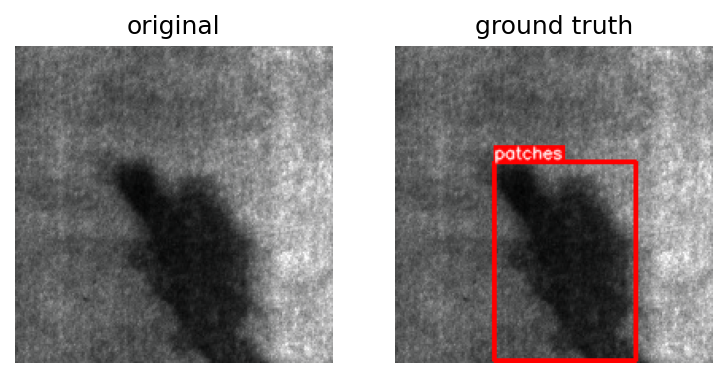

In [7]:
from sagemaker_defect_detection.utils.visualize import unnormalize_to_hwc, visualize

original_image_unnorm = unnormalize_to_hwc(original_image)

visualize(
    original_image_unnorm,
    [original_boxes],
    [original_labels],
    colors=[(255, 0, 0)],
    titles=["original", "ground truth"],
)

For our demo, we deploy an endpoint using a provided pretrained checkpoint. It takes about **10 minutes** to finish

In [8]:
%%time
from os import path as osp

from sagemaker.pytorch import PyTorchModel

demo_model = PyTorchModel(
    osp.join(s3_pretrained, "model.tar.gz"),
    role,
    entry_point="detector.py",
    source_dir=osp.join(sources, "source_dir.tar.gz"),
    framework_version="1.5",
    py_version="py3",
    sagemaker_session=sagemaker_session,
    name=sagemaker_config["SolutionPrefix"] + "-demo-model",
)

demo_detector = demo_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=sagemaker_config["SolutionPrefix"] + "-demo-endpoint",
)

-------!CPU times: user 28.1 s, sys: 4.65 s, total: 32.8 s
Wall time: 4min 1s


## Inference

We change the input depending on whether we are providing a list of images or a single image. Also the model requires a four dimensional array / tensor (with the first dimension as batch)

In [9]:
input = list(img.numpy() for img in images) if isinstance(images, list) else images.unsqueeze(0).numpy()

Now the input is ready and we can get some results

In [10]:
%%time
demo_predictions = demo_detector.predict(input)

CPU times: user 16.7 ms, sys: 152 µs, total: 16.8 ms
Wall time: 1.46 s


And finally, we visualize them as follows 

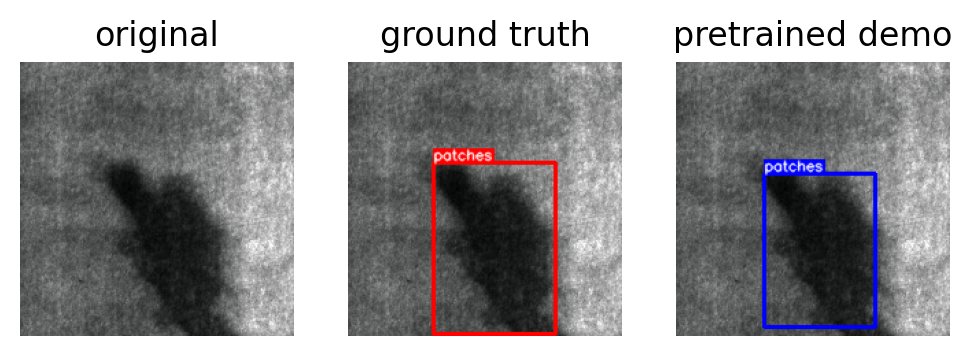

In [11]:
visualize(
    original_image_unnorm,
    [original_boxes, demo_predictions[0]["boxes"]],
    [original_labels, demo_predictions[0]["labels"]],
    colors=[(255, 0, 0), (0, 0, 255)],
    titles=["original", "ground truth", "pretrained demo"],
    dpi=200,
)

## Optional: Delete the endpoint and model

**Note:** to follow all the notebooks, it is required to keep demo model and the demo endpoint. It will be automatically deleted when you delete the entire resources/stack. However, if you need to, please uncomment and run the next cell

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [12]:
demo_detector.delete_model()
demo_detector.delete_endpoint()

### [Click here to continue](./1_retrain_from_checkpoint.ipynb)